# CHAPTER 3 SIMULATIONS

## Slow Migration Dynamics on two patches


=== Initial Conditions ===
S0: [500 500 500 500]
E0: [0 0 0 0]
I0: [0 0 2 1]
R0: [0 0 0 0]

=== Model Parameters ===
b (birth rate): [0.0437 0.0956 0.0759 0.0639]
mu (natural death): [0.0073 0.0073 0.0059 0.018 ]
phi (transmission): [0.0064 0.0074 0.0012 0.0097]
sigma (incubation): [0.1749 0.0819 0.0773 0.0775]
gamma (recovery): [0.0443 0.062  0.0546 0.0433]
delta (disease-death): [0.0034 0.0016 0.0022 0.0025]
omega (waning immunity): [0.1184 0.1678 0.08   0.1271]

Contact matrix C:
 [[0.     0.     0.6468 0.    ]
 [0.     0.     0.     0.8276]
 [0.3742 0.     0.     0.    ]
 [0.     0.5457 0.     0.    ]]

Migration matrix M:
 [[-0.0365  0.0365  0.      0.    ]
 [ 0.0365 -0.0365  0.      0.    ]
 [ 0.      0.     -0.0365  0.0365]
 [ 0.      0.      0.0365 -0.0365]]

Column sums of M (should be 0): [0. 0. 0. 0.]

--- Final values at t = 25 for ε = 0.5 ---
Species 1, Patch 1 – S: 47.29, E: 647.77, I: 827.46, R: 140.12
Species 1, Patch 2 – S: 111.86, E: 2334.71, I: 1142.45, R: 234.35
Sp

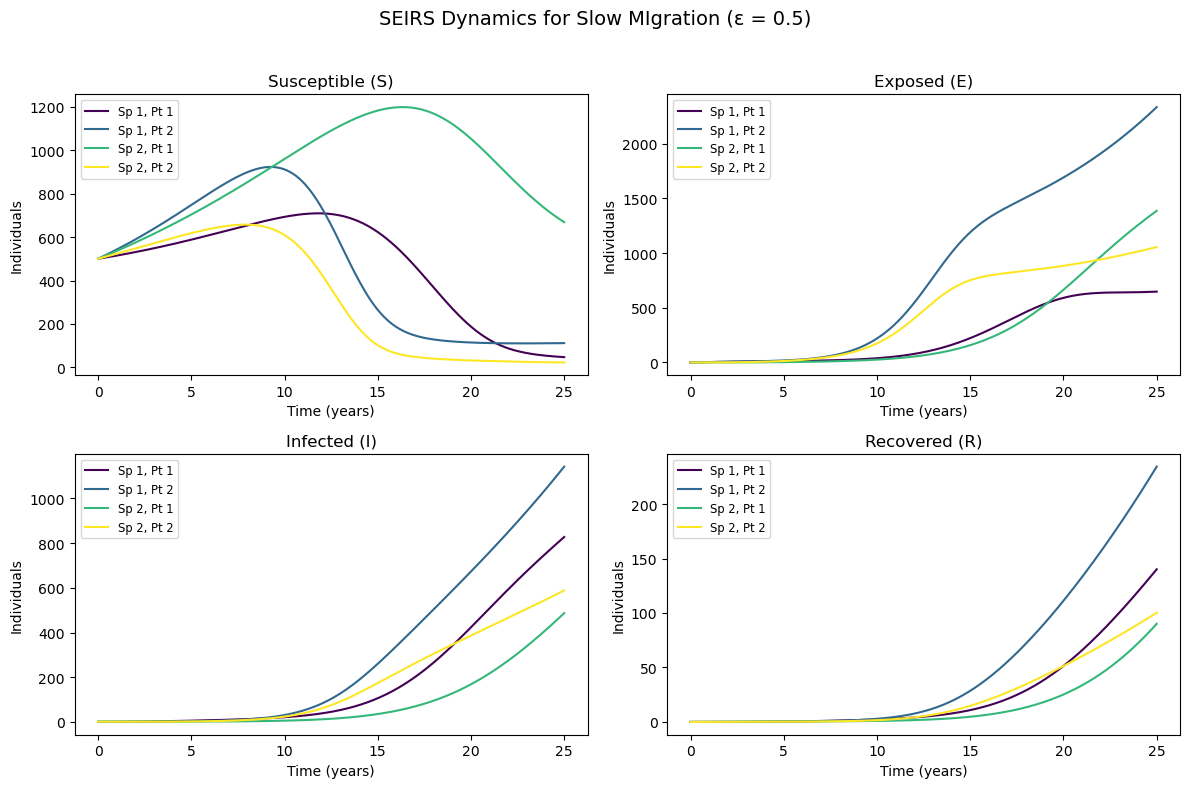

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

#Random Seed for Reproducibility 
np.random.seed(42)

#  Parameter Generators 
def generate_parameters(n):
    b     = np.random.uniform(0.01, 0.1,   n)
    mu    = np.random.uniform(0.005, 0.02, n)
    phi   = np.random.uniform(0.001, 0.01, n)
    sigma = np.random.uniform(0.05, 0.2,   n)
    gamma = np.random.uniform(0.02, 0.1,   n)
    delta = np.random.uniform(0.001, 0.005,n)
    omega = np.random.uniform(0.05, 0.2,   n)
    return b, mu, phi, sigma, gamma, delta, omega

#  Contact matrix fixed to C_A 
def generate_contact_matrix(n_species, n_patches):
    return np.array([
        [0.0000, 0.0000, 0.6468, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.8276],
        [0.3742, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5457, 0.0000, 0.0000]
    ])

#  Migration matrix fixed to M_A^X (column sums = 0) 
#  Migration matrix fixed to M_A^X (column sums = 0) 
def generate_conservative_migration_matrix(n_species, n_patches):
    # For 2 species × 2 patches → 4×4 matrix
    return np.array([
        [-0.0365,  0.0365,  0.0000,  0.0000],
        [ 0.0365, -0.0365,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0365, 0.0365],
        [ 0.0000,  0.0000,  0.0365, -0.0365]
    ])

#  SEIRS model 
def seirs_model(t, U, b, mu, phi, sigma, gamma, delta, omega, epsilon, C, M):
    S, E, I, R = np.split(U, 4)
    N = S + E + I + R
    Lambda    = b * N
    S = np.maximum(S, 1e-5)  # Avoid zero susceptibles
    contact_I = C @ I
    beta_I    = phi * contact_I * S
    eps_inv   = epsilon

    dSdt = Lambda - mu * S - beta_I + omega * R + eps_inv * (M @ S)
    dEdt = beta_I - sigma * E - mu * E           + eps_inv * (M @ E)
    dIdt = sigma * E - (mu + gamma + delta) * I  + eps_inv * (M @ I)
    dRdt = gamma * I - mu * R - omega * R        + eps_inv * (M @ R)

    return np.concatenate([dSdt, dEdt, dIdt, dRdt])

# Configuration 
n_species = 2
n_patches = 2
n         = n_species * n_patches

# Initial Conditions 
S0 = np.array([500, 500, 500, 500])
E0 = np.array([0, 0, 0, 0])
I0 = np.array([0, 0, 2, 1])  # Only species 2 infected
R0 = np.array([0, 0, 0, 0])
U0 = np.concatenate([S0, E0, I0, R0])

# Generate Parameters, Contact & Migration 
b, mu, phi, sigma, gamma, delta, omega = generate_parameters(n)
C = generate_contact_matrix(n_species, n_patches)
M = generate_conservative_migration_matrix(n_species, n_patches)

# Time Domain 
t_span = (0, 25)
t_eval = np.linspace(*t_span, 300)

# Simulation Function 
def run_simulation(epsilon):
    sol = solve_ivp(
        seirs_model, t_span, U0,
        args=(b, mu, phi, sigma, gamma, delta, omega, epsilon, C, M),
        method='RK45', t_eval=t_eval
    )
    S, E, I, R = np.split(sol.y, 4)

    print(f"\n--- Final values at t = {t_span[1]} for ε = {epsilon} ---")
    for i in range(n):
        sp = i // n_patches + 1
        pt = i % n_patches + 1
        print(f"Species {sp}, Patch {pt} – S: {S[i, -1]:.2f}, E: {E[i, -1]:.2f}, I: {I[i, -1]:.2f}, R: {R[i, -1]:.2f}")

    peak_I = np.max(I, axis=1)
    print("\n--- Peak Infected during simulation ---")
    for i in range(n):
        sp = i // n_patches + 1
        pt = i % n_patches + 1
        print(f"Species {sp}, Patch {pt}: Peak I = {peak_I[i]:.2f}")

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, n))
    for i in range(n):
        label = f"Sp {i // n_patches + 1}, Pt {i % n_patches + 1}"
        axs[0, 0].plot(sol.t, S[i], label=label, color=colors[i])
        axs[0, 1].plot(sol.t, E[i], label=label, color=colors[i])
        axs[1, 0].plot(sol.t, I[i], label=label, color=colors[i])
        axs[1, 1].plot(sol.t, R[i], label=label, color=colors[i])

    axs[0, 0].set_title("Susceptible (S)")
    axs[0, 1].set_title("Exposed (E)")
    axs[1, 0].set_title("Infected (I)")
    axs[1, 1].set_title("Recovered (R)")

    for ax in axs.flat:
        ax.set_xlabel("Time (years)")
        ax.set_ylabel("Individuals")
        ax.legend(fontsize="small")
        ax.grid(False)

    plt.suptitle(f"SEIRS Dynamics for Slow MIgration (ε = {epsilon})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('Slow_Chap3.pdf')
    plt.show()

# Display Initial Conditions & Parameters 
np.set_printoptions(precision=4, suppress=True)
print("\n=== Initial Conditions ===")
print("S0:", S0)
print("E0:", E0)
print("I0:", I0)
print("R0:", R0)

print("\n=== Model Parameters ===")
print("b (birth rate):", b)
print("mu (natural death):", mu)
print("phi (transmission):", phi)
print("sigma (incubation):", sigma)
print("gamma (recovery):", gamma)
print("delta (disease-death):", delta)
print("omega (waning immunity):", omega)
print("\nContact matrix C:\n", C)
print("\nMigration matrix M:\n", M)
print("\nColumn sums of M (should be 0):", np.sum(M, axis=0))

#  Run Simulation 
epsilon = 0.5
run_simulation(epsilon)


## No migration dynamics 


=== Initial Conditions ===
S0: [500 500 500 500]
E0: [0 0 0 0]
I0: [0 0 2 1]
R0: [0 0 0 0]

=== Model Parameters ===
b (birth rate): [0.0437 0.0956 0.0759 0.0639]
mu (natural death): [0.0073 0.0073 0.0059 0.018 ]
phi (transmission): [0.0064 0.0074 0.0012 0.0097]
sigma (incubation): [0.1749 0.0819 0.0773 0.0775]
gamma (recovery): [0.0443 0.062  0.0546 0.0433]
delta (disease-death): [0.0034 0.0016 0.0022 0.0025]
omega (waning immunity): [0.1184 0.1678 0.08   0.1271]

Contact matrix C:
 [[0.     0.     0.6468 0.    ]
 [0.     0.     0.     0.8276]
 [0.3742 0.     0.     0.    ]
 [0.     0.5457 0.     0.    ]]

Migration matrix M:
 [[-0.0365  0.0365  0.      0.    ]
 [ 0.0365 -0.0365  0.      0.    ]
 [ 0.      0.     -0.0365  0.0365]
 [ 0.      0.      0.0365 -0.0365]]

Column sums of M (should be 0): [0. 0. 0. 0.]

--- Final values at t = 25 for ε = 0 ---
Species 1, Patch 1 – S: 52.98, E: 517.47, I: 572.70, R: 85.76
Species 1, Patch 2 – S: 139.03, E: 2771.16, I: 1332.46, R: 274.56
Speci

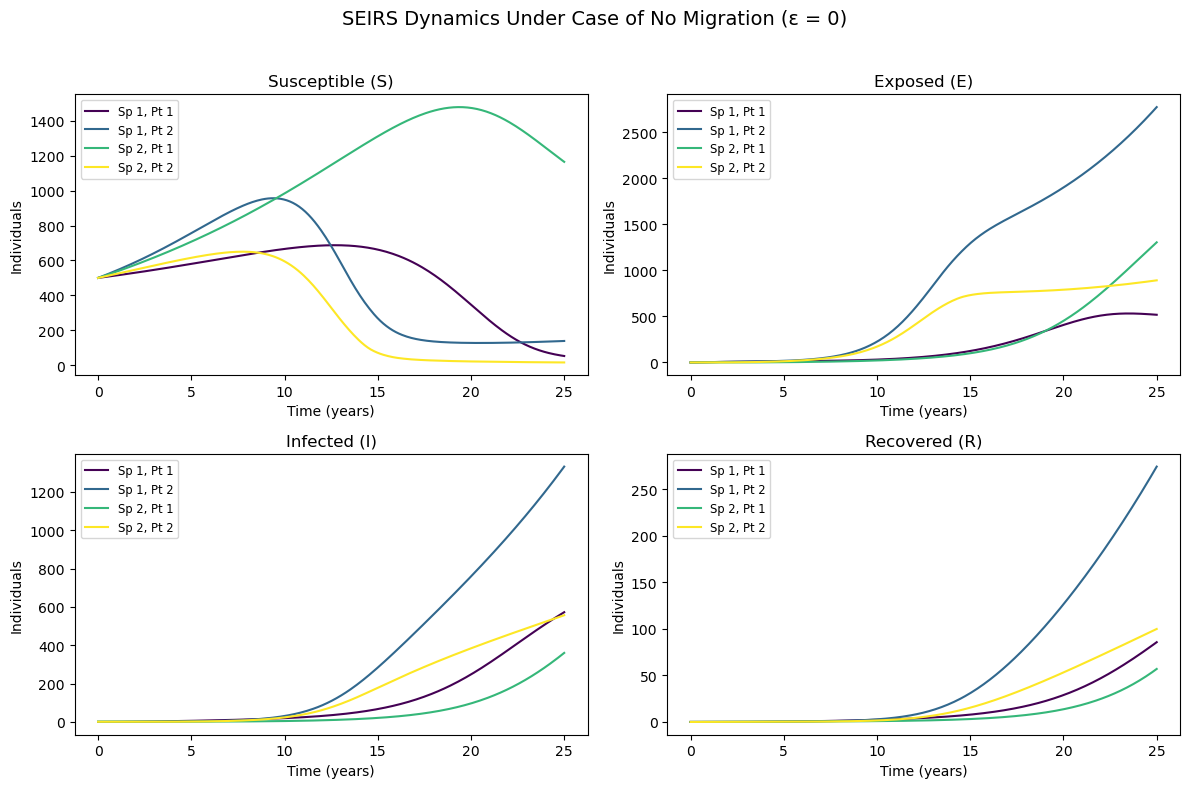

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

#  Random Seed for Reproducibility 
np.random.seed(42)

#  Parameter Generators 
def generate_parameters(n):
    b     = np.random.uniform(0.01, 0.1,   n)
    mu    = np.random.uniform(0.005, 0.02, n)
    phi   = np.random.uniform(0.001, 0.01, n)
    sigma = np.random.uniform(0.05, 0.2,   n)
    gamma = np.random.uniform(0.02, 0.1,   n)
    delta = np.random.uniform(0.001, 0.005,n)
    omega = np.random.uniform(0.05, 0.2,   n)
    return b, mu, phi, sigma, gamma, delta, omega

#  Contact matrix fixed to C_A 
def generate_contact_matrix(n_species, n_patches):
    return np.array([
        [0.0000, 0.0000, 0.6468, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.8276],
        [0.3742, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5457, 0.0000, 0.0000]
    ])

#  Migration matrix fixed to M_A^X (column sums = 0)
def generate_conservative_migration_matrix(n_species, n_patches):
    # For 2 species × 2 patches → 4×4 matrix
    return np.array([
        [-0.0365,  0.0365,  0.0000,  0.0000],
        [ 0.0365, -0.0365,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0365, 0.0365],
        [ 0.0000,  0.0000,  0.0365, -0.0365]
    ])

#  SEIRS model
def seirs_model(t, U, b, mu, phi, sigma, gamma, delta, omega, epsilon, C, M):
    S, E, I, R = np.split(U, 4)
    N = S + E + I + R
    Lambda    = b * N
    S = np.maximum(S, 1e-5)  # Avoid zero susceptibles
    contact_I = C @ I
    beta_I    = phi * contact_I * S
    eps_inv   = epsilon

    dSdt = Lambda - mu * S - beta_I + omega * R + eps_inv * (M @ S)
    dEdt = beta_I - sigma * E - mu * E           + eps_inv * (M @ E)
    dIdt = sigma * E - (mu + gamma + delta) * I  + eps_inv * (M @ I)
    dRdt = gamma * I - mu * R - omega * R        + eps_inv * (M @ R)

    return np.concatenate([dSdt, dEdt, dIdt, dRdt])

#  Configuration 
n_species = 2
n_patches = 2
n         = n_species * n_patches

#  Initial Conditions
S0 = np.array([500, 500, 500, 500])
E0 = np.array([0, 0, 0, 0])
I0 = np.array([0, 0, 2, 1])  # Only species 2 infected
R0 = np.array([0, 0, 0, 0])
U0 = np.concatenate([S0, E0, I0, R0])

#  Generate Parameters, Contact & Migration 
b, mu, phi, sigma, gamma, delta, omega = generate_parameters(n)
C = generate_contact_matrix(n_species, n_patches)
M = generate_conservative_migration_matrix(n_species, n_patches)

#  Time Domain 
t_span = (0, 25)
t_eval = np.linspace(*t_span, 300)

#  Simulation Function 
def run_simulation(epsilon):
    sol = solve_ivp(
        seirs_model, t_span, U0,
        args=(b, mu, phi, sigma, gamma, delta, omega, epsilon, C, M),
        method='RK45', t_eval=t_eval
    )
    S, E, I, R = np.split(sol.y, 4)

    print(f"\n--- Final values at t = {t_span[1]} for ε = {epsilon} ---")
    for i in range(n):
        sp = i // n_patches + 1
        pt = i % n_patches + 1
        print(f"Species {sp}, Patch {pt} – S: {S[i, -1]:.2f}, E: {E[i, -1]:.2f}, I: {I[i, -1]:.2f}, R: {R[i, -1]:.2f}")

    peak_I = np.max(I, axis=1)
    print("\n--- Peak Infected during simulation ---")
    for i in range(n):
        sp = i // n_patches + 1
        pt = i % n_patches + 1
        print(f"Species {sp}, Patch {pt}: Peak I = {peak_I[i]:.2f}")

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, n))
    for i in range(n):
        label = f"Sp {i // n_patches + 1}, Pt {i % n_patches + 1}"
        axs[0, 0].plot(sol.t, S[i], label=label, color=colors[i])
        axs[0, 1].plot(sol.t, E[i], label=label, color=colors[i])
        axs[1, 0].plot(sol.t, I[i], label=label, color=colors[i])
        axs[1, 1].plot(sol.t, R[i], label=label, color=colors[i])

    axs[0, 0].set_title("Susceptible (S)")
    axs[0, 1].set_title("Exposed (E)")
    axs[1, 0].set_title("Infected (I)")
    axs[1, 1].set_title("Recovered (R)")

    for ax in axs.flat:
        ax.set_xlabel("Time (years)")
        ax.set_ylabel("Individuals")
        ax.legend(fontsize="small")
        ax.grid(False)

    plt.suptitle(f"SEIRS Dynamics Under Case of No Migration (ε = {epsilon})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('No_Chap3.pdf')
    plt.show()

#  Display Initial Conditions & Parameters 
np.set_printoptions(precision=4, suppress=True)
print("\n=== Initial Conditions ===")
print("S0:", S0)
print("E0:", E0)
print("I0:", I0)
print("R0:", R0)

print("\n=== Model Parameters ===")
print("b (birth rate):", b)
print("mu (natural death):", mu)
print("phi (transmission):", phi)
print("sigma (incubation):", sigma)
print("gamma (recovery):", gamma)
print("delta (disease-death):", delta)
print("omega (waning immunity):", omega)
print("\nContact matrix C:\n", C)
print("\nMigration matrix M:\n", M)
print("\nColumn sums of M (should be 0):", np.sum(M, axis=0))

#  Run Simulation 
epsilon = 0
run_simulation(epsilon)


## Fast Migration Dynamics


=== Initial Conditions ===
S0: [500 500 500 500]
E0: [0 0 0 0]
I0: [0 0 2 1]
R0: [0 0 0 0]

=== Model Parameters ===
b (birth rate): [0.0437 0.0956 0.0759 0.0639]
mu (natural death): [0.0073 0.0073 0.0059 0.018 ]
phi (transmission): [0.0064 0.0074 0.0012 0.0097]
sigma (incubation): [0.1749 0.0819 0.0773 0.0775]
gamma (recovery): [0.0443 0.062  0.0546 0.0433]
delta (disease-death): [0.0034 0.0016 0.0022 0.0025]
omega (waning immunity): [0.1184 0.1678 0.08   0.1271]

Contact matrix C:
 [[0.     0.     0.6468 0.    ]
 [0.     0.     0.     0.8276]
 [0.3742 0.     0.     0.    ]
 [0.     0.5457 0.     0.    ]]

Migration matrix M:
 [[-0.0365  0.0365  0.      0.    ]
 [ 0.0365 -0.0365  0.      0.    ]
 [ 0.      0.     -0.0365  0.0365]
 [ 0.      0.      0.0365 -0.0365]]

Column sums of M (should be 0): [0. 0. 0. 0.]

--- Final values at t = 25 for ε = 0.003 ---
Species 1, Patch 1 – S: 53.92, E: 1063.04, I: 1020.57, R: 209.75
Species 1, Patch 2 – S: 56.00, E: 1070.42, I: 1015.90, R: 210.05

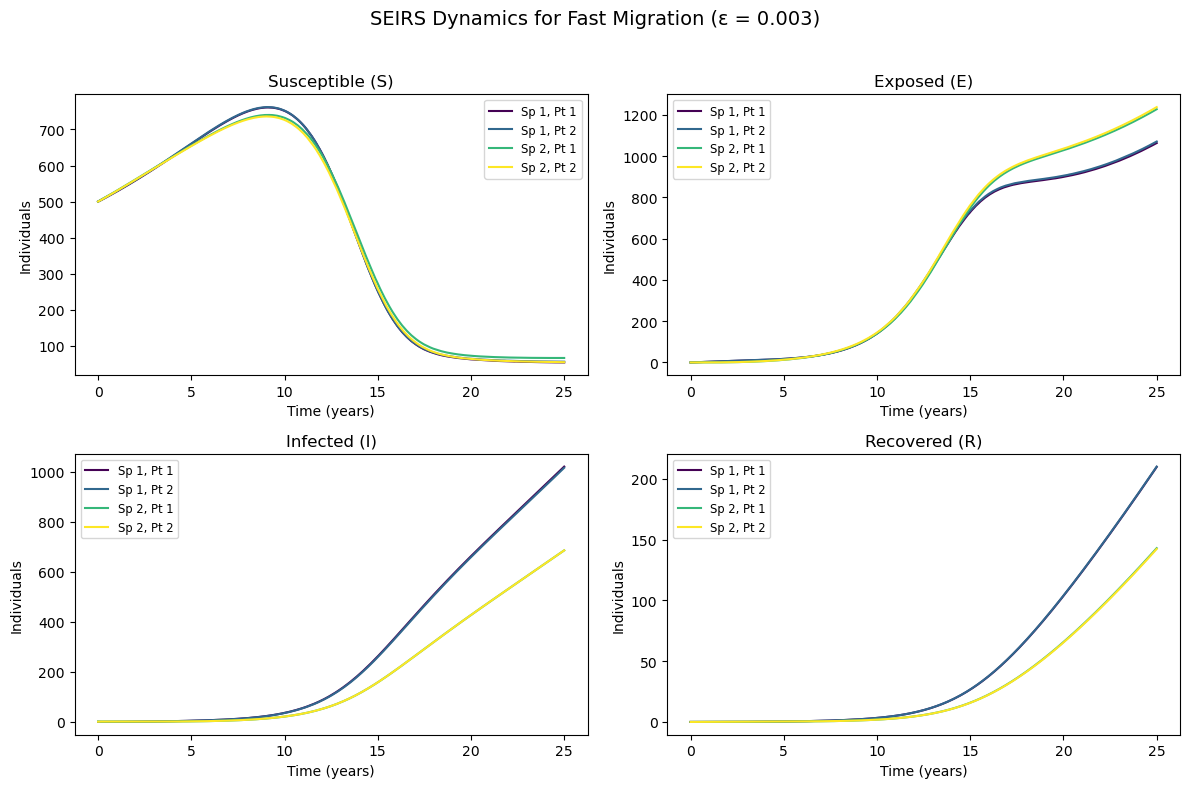

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

#  Random Seed for Reproducibility 
np.random.seed(42)

#  Parameter Generators 
def generate_parameters(n):
    b     = np.random.uniform(0.01, 0.1,   n)
    mu    = np.random.uniform(0.005, 0.02, n)
    phi   = np.random.uniform(0.001, 0.01, n)
    sigma = np.random.uniform(0.05, 0.2,   n)
    gamma = np.random.uniform(0.02, 0.1,   n)
    delta = np.random.uniform(0.001, 0.005,n)
    omega = np.random.uniform(0.05, 0.2,   n)
    return b, mu, phi, sigma, gamma, delta, omega

#  Contact matrix fixed to C_A 
def generate_contact_matrix(n_species, n_patches):
    return np.array([
        [0.0000, 0.0000, 0.6468, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.8276],
        [0.3742, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5457, 0.0000, 0.0000]
    ])

#  Migration matrix fixed to M_A^X (column sums = 0)
def generate_conservative_migration_matrix(n_species, n_patches):
    # For 2 species × 2 patches → 4×4 matrix
    return np.array([
        [-0.0365,  0.0365,  0.0000,  0.0000],
        [ 0.0365, -0.0365,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0365, 0.0365],
        [ 0.0000,  0.0000,  0.0365, -0.0365]
    ])

#  SEIRS model 
def seirs_model(t, U, b, mu, phi, sigma, gamma, delta, omega, epsilon, C, M):
    S, E, I, R = np.split(U, 4)
    N = S + E + I + R
    Lambda    = b * N
    S = np.maximum(S, 1e-5)  # Avoid zero susceptibles
    contact_I = C @ I
    beta_I    = phi * contact_I * S
    eps_inv   = 1/epsilon

    dSdt = Lambda - mu * S - beta_I + omega * R + eps_inv * (M @ S)
    dEdt = beta_I - sigma * E - mu * E           + eps_inv * (M @ E)
    dIdt = sigma * E - (mu + gamma + delta) * I  + eps_inv * (M @ I)
    dRdt = gamma * I - mu * R - omega * R        + eps_inv * (M @ R)

    return np.concatenate([dSdt, dEdt, dIdt, dRdt])

#Configuration
n_species = 2
n_patches = 2
n         = n_species * n_patches

#  Initial Conditions 
S0 = np.array([500, 500, 500, 500])
E0 = np.array([0, 0, 0, 0])
I0 = np.array([0, 0, 2, 1])  # Only species 2 infected
R0 = np.array([0, 0, 0, 0])
U0 = np.concatenate([S0, E0, I0, R0])

#  Generate Parameters, Contact & Migration 
b, mu, phi, sigma, gamma, delta, omega = generate_parameters(n)
C = generate_contact_matrix(n_species, n_patches)
M = generate_conservative_migration_matrix(n_species, n_patches)

#  Time Domain 
t_span = (0, 25)
t_eval = np.linspace(*t_span, 300)

#  Simulation Function 
def run_simulation(epsilon):
    sol = solve_ivp(
        seirs_model, t_span, U0,
        args=(b, mu, phi, sigma, gamma, delta, omega, epsilon, C, M),
        method='RK45', t_eval=t_eval
    )
    S, E, I, R = np.split(sol.y, 4)

    print(f"\n--- Final values at t = {t_span[1]} for ε = {epsilon} ---")
    for i in range(n):
        sp = i // n_patches + 1
        pt = i % n_patches + 1
        print(f"Species {sp}, Patch {pt} – S: {S[i, -1]:.2f}, E: {E[i, -1]:.2f}, I: {I[i, -1]:.2f}, R: {R[i, -1]:.2f}")

    peak_I = np.max(I, axis=1)
    print("\n--- Peak Infected during simulation ---")
    for i in range(n):
        sp = i // n_patches + 1
        pt = i % n_patches + 1
        print(f"Species {sp}, Patch {pt}: Peak I = {peak_I[i]:.2f}")

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, n))
    for i in range(n):
        label = f"Sp {i // n_patches + 1}, Pt {i % n_patches + 1}"
        axs[0, 0].plot(sol.t, S[i], label=label, color=colors[i])
        axs[0, 1].plot(sol.t, E[i], label=label, color=colors[i])
        axs[1, 0].plot(sol.t, I[i], label=label, color=colors[i])
        axs[1, 1].plot(sol.t, R[i], label=label, color=colors[i])

    axs[0, 0].set_title("Susceptible (S)")
    axs[0, 1].set_title("Exposed (E)")
    axs[1, 0].set_title("Infected (I)")
    axs[1, 1].set_title("Recovered (R)")

    for ax in axs.flat:
        ax.set_xlabel("Time (years)")
        ax.set_ylabel("Individuals")
        ax.legend(fontsize="small")
        ax.grid(False)

    plt.suptitle(f"SEIRS Dynamics for Fast Migration (ε = {epsilon})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('Fast_Chap3.pdf')
    plt.show()

#  Display Initial Conditions & Parameters 
np.set_printoptions(precision=4, suppress=True)
print("\n=== Initial Conditions ===")
print("S0:", S0)
print("E0:", E0)
print("I0:", I0)
print("R0:", R0)

print("\n=== Model Parameters ===")
print("b (birth rate):", b)
print("mu (natural death):", mu)
print("phi (transmission):", phi)
print("sigma (incubation):", sigma)
print("gamma (recovery):", gamma)
print("delta (disease-death):", delta)
print("omega (waning immunity):", omega)
print("\nContact matrix C:\n", C)
print("\nMigration matrix M:\n", M)
print("\nColumn sums of M (should be 0):", np.sum(M, axis=0))

#  Run Simulation
epsilon = 0.003
run_simulation(epsilon)


# CHAPTER 4 SIMULATIONS FOR MALARIA DYNAMICS

 ## Migration Dynamics with $\mathcal{R}_{01}\approx 1.2$ and other  $\mathcal{R}_{0i}<1$

## 1. Case of Slow Migration


--- Parameters for ε = 0.001 ---
birth_rate: 0.00016913894324853228
mu_h (human death): 3.913894324853229e-05
mu_v (mosquito death): 0.1
sigma_h (human incubation): 0.1
sigma_v (mosquito incubation): 0.14285714285714285
gamma_h (human recovery): 0.07142857142857142
delta_h (disease-induced death): 0.001
omega_h (waning immunity): 0.005555555555555556
beta_h: [0.37009956 0.1        0.03      ]
beta_v: [0.05 0.1  0.3 ]
R0_mig: [1.224744871391589, 0.9003292151387299, 0.8541272891490407]
Initial total humans = 5998.00, Final total humans = 6787.27

--- Parameters for ε = 0.05 ---
birth_rate: 0.00016913894324853228
mu_h (human death): 3.913894324853229e-05
mu_v (mosquito death): 0.1
sigma_h (human incubation): 0.1
sigma_v (mosquito incubation): 0.14285714285714285
gamma_h (human recovery): 0.07142857142857142
delta_h (disease-induced death): 0.001
omega_h (waning immunity): 0.005555555555555556
beta_h: [0.38820924 0.1        0.03      ]
beta_v: [0.05 0.1  0.3 ]
R0_mig: [1.2247448713915892,

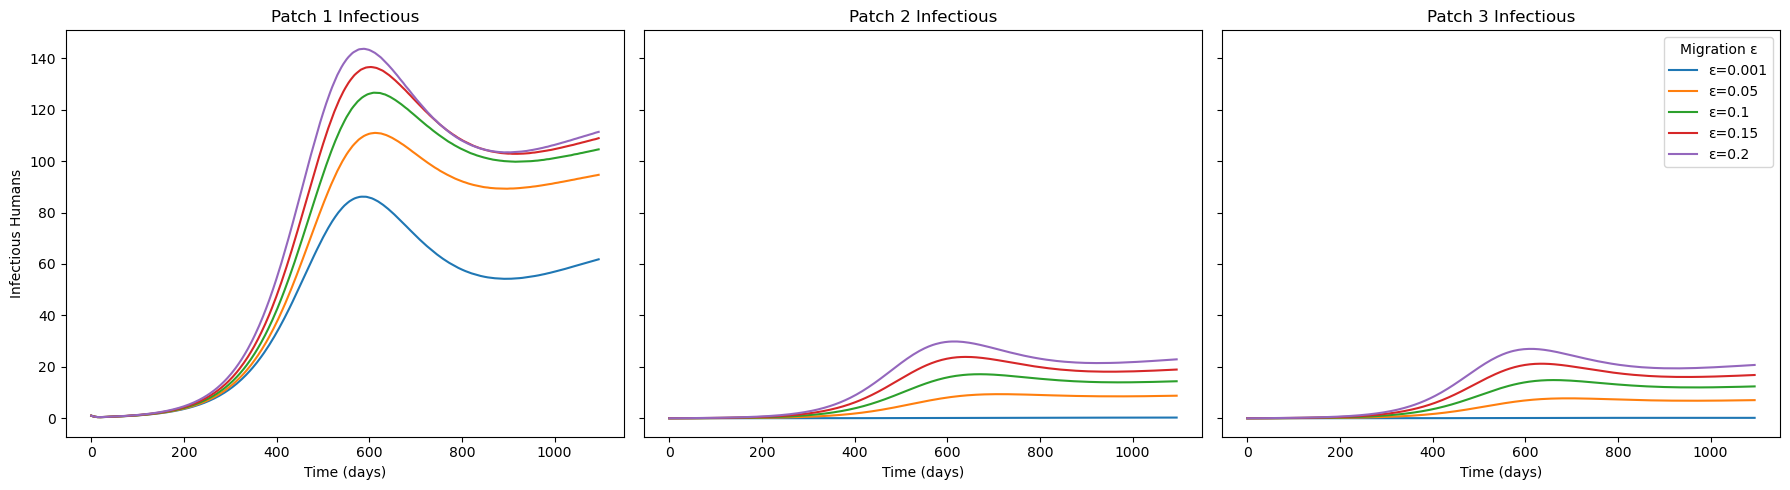

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Model Parameters
num_patches = 3
N_H = np.array([2000, 2000, 2000])
N_V = np.array([5000, 5000, 5000])

sigma_h = 1/10     # incubation rate (humans)
sigma_v = 1/7      # incubation rate (mosquitoes)
gamma_h = 1/14     # recovery rate (humans)
mu_h = 1/(70*365)  # human death rate
mu_v = 1/10        # mosquito death rate
delta_h = 0.001    # disease-induced death rate
omega_h = 1/180    # loss of immunity

# Growing population: birth rate slightly above natural death
birth_rate = mu_h + 0.00013

# Transmission parameters
beta_v = np.array([0.05, 0.1, 0.3])
raw_mig = np.array([
    [0.0,  0.05, 0.05],
    [0.05, 0.0,  0.05],
    [0.05, 0.05, 0.0 ]
])

def compute_threshold_beta(epsilon):
    """Threshold β_h such that local R0_mig=1 in patch 1."""
    inflow_1 = raw_mig[:,0].sum()
    return ((sigma_h + mu_h + epsilon * inflow_1)
            * (mu_h + gamma_h + delta_h)
            * (sigma_v + mu_v)
            * mu_v
           ) / (sigma_h * sigma_v * beta_v[0])

# Prepare plotting
epsilons = [0.001, 0.05, 0.1, 0.15, 0.20]
t_eval = np.linspace(0, 365*3, 500)
n_comp = 7

fig, axes = plt.subplots(1, num_patches, figsize=(18, 5), sharey=True)

for epsilon in epsilons:
    eps = epsilon
    threshold_beta_h0 = compute_threshold_beta(epsilon)
    beta_h = np.array([threshold_beta_h0 * 1.5, 0.1, 0.03])

    # Print parameters
    print(f"\n--- Parameters for ε = {epsilon} ---")
    print("birth_rate:", birth_rate)
    print("mu_h (human death):", mu_h)
    print("mu_v (mosquito death):", mu_v)
    print("sigma_h (human incubation):", sigma_h)
    print("sigma_v (mosquito incubation):", sigma_v)
    print("gamma_h (human recovery):", gamma_h)
    print("delta_h (disease-induced death):", delta_h)
    print("omega_h (waning immunity):", omega_h)
    print("beta_h:", beta_h)
    print("beta_v:", beta_v)

    # Build migration matrix
    M = raw_mig.copy()
    for j in range(num_patches):
        M[j, j] = - raw_mig[:, j].sum()

    # Compute R0_mig
    R0_vals = []
    for i in range(num_patches):
        inflow_i = raw_mig[:, i].sum()
        numerator   = beta_h[i] * beta_v[i] * sigma_h * sigma_v
        denominator = (sigma_h + mu_h + eps * inflow_i)\
                    * (mu_h + gamma_h + delta_h)\
                    * (sigma_v + mu_v)\
                    * mu_v
        R0_vals.append(np.sqrt(numerator / denominator))
    print("R0_mig:", R0_vals)

    # ODE function
    def seirs_metapop(t, Y_flat):
        Y = Y_flat.reshape((num_patches, n_comp))
        dY = np.zeros_like(Y)
        for i in range(num_patches):
            S_H, E_H, I_H, R_H, S_V, E_V, I_V = Y[i]
            λ_H = beta_h[i] * I_V / N_V[i]
            λ_V = beta_v[i] * I_H / N_H[i]
            Λ_H = birth_rate * N_H[i]

            dS_H = Λ_H - λ_H * S_H + omega_h * R_H - mu_h * S_H
            dE_H = λ_H * S_H - sigma_h * E_H - mu_h * E_H
            dI_H = sigma_h * E_H - (gamma_h + mu_h + delta_h) * I_H
            dR_H = gamma_h * I_H - omega_h * R_H - mu_h * R_H

            dS_V = -λ_V * S_V + mu_v * (N_V[i] - S_V)
            dE_V = λ_V * S_V - sigma_v * E_V - mu_v * E_V
            dI_V = sigma_v * E_V - mu_v * I_V

            for j in range(num_patches):
                dS_H += eps * M[i, j] * Y[j, 0]
                dE_H += eps * M[i, j] * Y[j, 1]
                dR_H += eps * M[i, j] * Y[j, 3]

            dY[i] = [dS_H, dE_H, dI_H, dR_H, dS_V, dE_V, dI_V]
        return dY.flatten()

    # Initial state
    Y0 = []
    for i in range(num_patches):
        Y0 += [N_H[i] - 1, 0, (1 if i == 0 else 0), 0, N_V[i], 0, 0]
    Y0 = np.array(Y0)

    # Solve
    sol = solve_ivp(seirs_metapop, (t_eval[0], t_eval[-1]), Y0,
                    t_eval=t_eval, method='RK45')

    # Check population conservation
    total_H = sol.y.reshape((num_patches, n_comp, -1))[:, :4, :].sum(axis=(0, 1))
    print(f"Initial total humans = {total_H[0]:.2f}, Final total humans = {total_H[-1]:.2f}")

    # Plot infections
    for i in range(num_patches):
        axes[i].plot(t_eval, sol.y[i*n_comp + 2], label=f'ε={epsilon}')
        axes[i].set_title(f'Patch {i+1} Infectious')
        axes[i].set_xlabel('Time (days)')
        if i == 0:
            axes[i].set_ylabel('Infectious Humans')

axes[-1].legend(title='Migration ε')
plt.tight_layout()
plt.savefig('Slow_mig.pdf')
plt.show()



# Malaria Dynamics in 3 Connected Patches with $\mathcal{R_{0i}<1}$ 

## 1. Low Migration Analysis


Epsilon = 0.001
Patch   R0_mig
    1 0.774597
    2 0.900329
    3 0.854127
Initial total humans = 5998.00, Final total humans = 6834.11

Epsilon = 0.05
Patch   R0_mig
    1 0.774597
    2 0.879079
    3 0.833967
Initial total humans = 5998.00, Final total humans = 6834.10

Epsilon = 0.1
Patch   R0_mig
    1 0.774597
    2 0.858874
    3 0.814800
Initial total humans = 5998.00, Final total humans = 6834.10

Epsilon = 0.15
Patch   R0_mig
    1 0.774597
    2 0.840002
    3 0.796896
Initial total humans = 5998.00, Final total humans = 6834.09

Epsilon = 0.2
Patch   R0_mig
    1 0.774597
    2 0.822322
    3 0.780123
Initial total humans = 5998.00, Final total humans = 6834.09


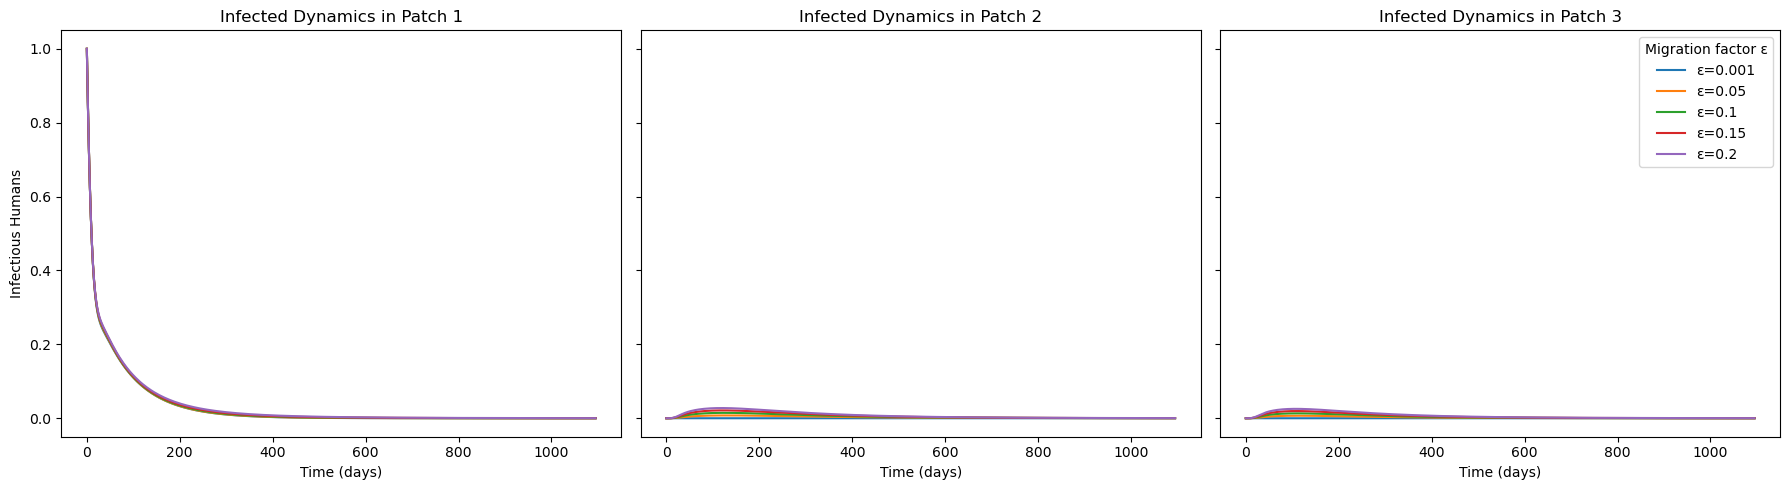

In [6]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Model Parameters
num_patches = 3
N_H = np.array([2000, 2000, 2000])
N_V = np.array([5000, 5000, 5000])

sigma_h = 1/10     # incubation rate (humans)
sigma_v = 1/7      # incubation rate (mosquitoes)
gamma_h = 1/14     # recovery rate (humans)
mu_h = 1/(70*365)  # human death rate
mu_v = 1/10        # mosquito death rate
delta_h = 0.001     # disease-induced death rate
omega_h = 1/180    # loss of immunity

# Growing population: birth rate slightly above natural death
birth_rate = mu_h + 0.00013

# Transmission parameters: patch 2 & 3 baseline
beta_v = np.array([0.05, 0.1, 0.3])
raw_mig = np.array([[0.0,0.05,0.05],[0.05,0.0,0.05],[0.05,0.05,0.0]])

# Compute threshold beta_h0 for R0_migration = 1 (using eps placeholder)
def compute_threshold_beta(epsilon):
    eps = 1*epsilon
    a = sigma_h + mu_h + eps * raw_mig[0].sum()
    b = mu_h + gamma_h + delta_h
    c = sigma_v + mu_v
    d = mu_v
    return (a * b * c * d) / (sigma_h * sigma_v * beta_v[0])

# Prepare plotting
epsilons = [0.001,0.05, 0.1, 0.15, 0.20]
t_eval = np.linspace(0, 365*3, 500)
n_comp = 7

fig, axes = plt.subplots(1, num_patches, figsize=(18, 5), sharey=True)

for epsilon in epsilons:
    eps = epsilon
    # Compute beta_h array with patch1 above threshold
    threshold_beta_h0 = compute_threshold_beta(epsilon)
    beta_h = np.array([threshold_beta_h0 * 0.6, 0.1, 0.03])

    # Build column-zero-sum migration matrix M
    M = raw_mig.copy()
    for j in range(num_patches):
        M[j, j] = -raw_mig[:, j].sum()
    
    # R0 with migration
    R0_vals = []
    for i in range(num_patches):
        num = beta_h[i] * beta_v[i] * sigma_h * sigma_v
        denom = (sigma_h + mu_h + eps * raw_mig[i].sum()) * (mu_h + gamma_h + delta_h) * (sigma_v + mu_v) * mu_v
        R0_vals.append(np.sqrt(num / denom))
    df_R0 = pd.DataFrame({'Patch': ['1','2','3'], 'R0_mig': R0_vals})
    print(f"\nEpsilon = {epsilon}")
    print(df_R0.to_string(index=False))

    # ODE
    def seirs_metapop(t, Y_flat):
        Y = Y_flat.reshape((num_patches, n_comp))
        dY = np.zeros_like(Y)
        for i in range(num_patches):
            S_H, E_H, I_H, R_H, S_V, E_V, I_V = Y[i]
            lambda_H = beta_h[i] * I_V / N_V[i]
            lambda_V = beta_v[i] * I_H / N_H[i]
            Lambda_H = birth_rate * N_H[i]
            dS_H = Lambda_H - lambda_H*S_H + omega_h*R_H - mu_h*S_H
            dE_H = lambda_H*S_H - sigma_h*E_H - mu_h*E_H
            dI_H = sigma_h*E_H - (gamma_h+mu_h+delta_h)*I_H
            dR_H = gamma_h*I_H - omega_h*R_H - mu_h*R_H
            dS_V = -lambda_V*S_V + mu_v*(N_V[i]-S_V)
            dE_V = lambda_V*S_V - sigma_v*E_V - mu_v*E_V
            dI_V = sigma_v*E_V - mu_v*I_V
            for j in range(num_patches):
                dS_H += eps * (M[i,j] * Y[j,0])
                dE_H += eps * (M[i,j] * Y[j,1])
                dR_H += eps * (M[i,j] * Y[j,3])
            dY[i] = [dS_H, dE_H, dI_H, dR_H, dS_V, dE_V, dI_V]
        return dY.flatten()

    # Initial conditions
    Y0 = []
    for i in range(num_patches):
        Y0 += [N_H[i]-1, 0, 1 if i==0 else 0, 0, N_V[i], 0, 0]
    Y0 = np.array(Y0)

    sol = solve_ivp(seirs_metapop, (t_eval[0], t_eval[-1]), Y0, t_eval=t_eval, method='RK45')

    # Check populations
    total_H = sol.y.reshape((num_patches, n_comp, -1))[:,:4,:].sum(axis=(0,1))
    print(f"Initial total humans = {total_H[0]:.2f}, Final total humans = {total_H[-1]:.2f}")

    # Plot infectious humans
    for i in range(num_patches):
        axes[i].plot(t_eval, sol.y[i*n_comp+2], label=f'ε={epsilon}')
        axes[i].set_title(f'Infected Dynamics in Patch {i+1}')
        axes[i].set_xlabel('Time (days)')
        if i == 0:
            axes[i].set_ylabel('Infectious Humans')
        axes[i].grid(False)

axes[-1].legend(title='Migration factor ε')
plt.tight_layout()
#plt.savefig('Slow_mig2.pdf')
plt.show()


## 2. NO migration


Epsilon = 0.001
Patch   R0_mig
    1 0.774597
    2 0.900779
    3 0.854554
Initial total humans = 5998.00, Final total humans = 6834.11

Epsilon = 0.05
Patch   R0_mig
    1 0.774597
    2 0.900779
    3 0.854554
Initial total humans = 5998.00, Final total humans = 6834.11

Epsilon = 0.1
Patch   R0_mig
    1 0.774597
    2 0.900779
    3 0.854554
Initial total humans = 5998.00, Final total humans = 6834.11

Epsilon = 0.15
Patch   R0_mig
    1 0.774597
    2 0.900779
    3 0.854554
Initial total humans = 5998.00, Final total humans = 6834.11

Epsilon = 0.2
Patch   R0_mig
    1 0.774597
    2 0.900779
    3 0.854554
Initial total humans = 5998.00, Final total humans = 6834.11


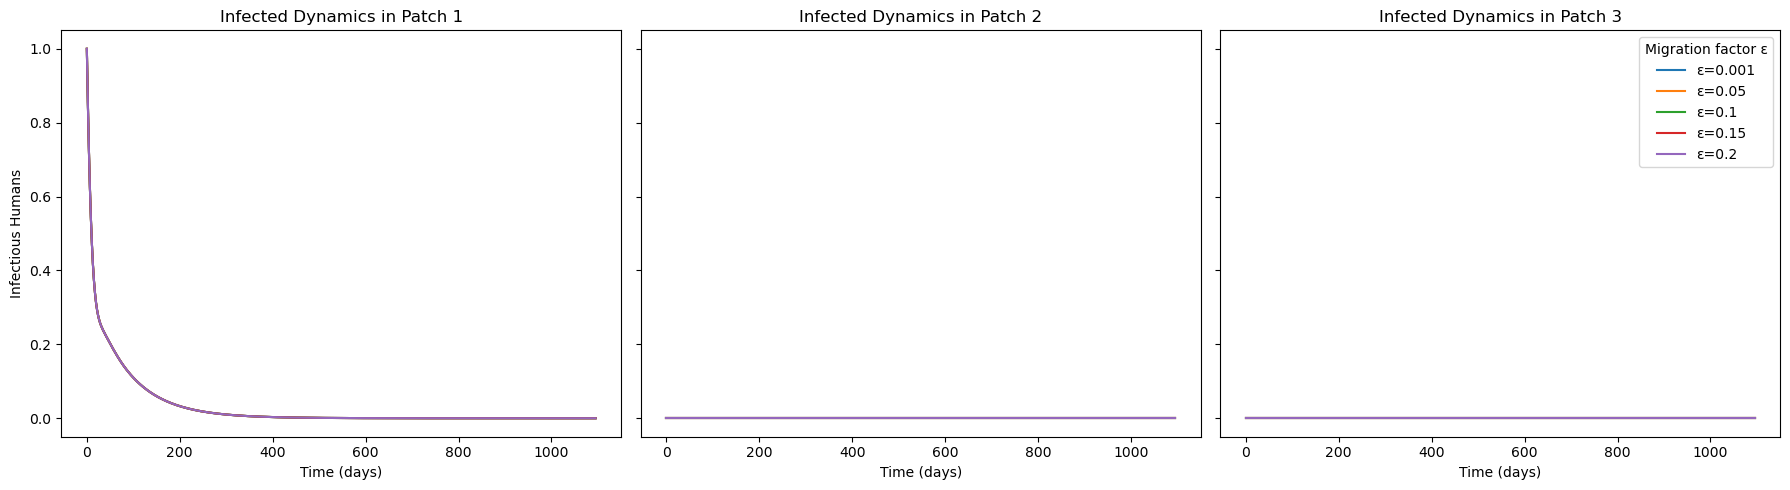

In [8]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Model Parameters
num_patches = 3
N_H = np.array([2000, 2000, 2000])
N_V = np.array([5000, 5000, 5000])

sigma_h = 1/10     # incubation rate (humans)
sigma_v = 1/7      # incubation rate (mosquitoes)
gamma_h = 1/14     # recovery rate (humans)
mu_h = 1/(70*365)  # human death rate
mu_v = 1/10        # mosquito death rate
delta_h = 0.001     # disease-induced death rate
omega_h = 1/180    # loss of immunity

# Growing population: birth rate slightly above natural death
birth_rate = mu_h + 0.00013

# Transmission parameters: patch 2 & 3 baseline
beta_v = np.array([0.05, 0.1, 0.3])
raw_mig =0* np.array([[0.0,0.05,0.05],[0.05,0.0,0.05],[0.05,0.05,0.0]])

# Compute threshold beta_h0 for R0_migration = 1 (using eps placeholder)
def compute_threshold_beta(epsilon):
    eps = 1*epsilon
    a = sigma_h + mu_h + eps * raw_mig[0].sum()
    b = mu_h + gamma_h + delta_h
    c = sigma_v + mu_v
    d = mu_v
    return (a * b * c * d) / (sigma_h * sigma_v * beta_v[0])

# Prepare plotting
epsilons = [0.001,0.05, 0.1, 0.15, 0.20]
t_eval = np.linspace(0, 365*3, 500)
n_comp = 7

fig, axes = plt.subplots(1, num_patches, figsize=(18, 5), sharey=True)

for epsilon in epsilons:
    eps = epsilon
    # Compute beta_h array with patch1 above threshold
    threshold_beta_h0 = compute_threshold_beta(epsilon)
    beta_h = np.array([threshold_beta_h0 * 0.6, 0.1, 0.03])

    # Build column-zero-sum migration matrix M
    M = raw_mig.copy()
    for j in range(num_patches):
        M[j, j] = -raw_mig[:, j].sum()
    
    # R0 with migration
    R0_vals = []
    for i in range(num_patches):
        num = beta_h[i] * beta_v[i] * sigma_h * sigma_v
        denom = (sigma_h + mu_h + eps * raw_mig[i].sum()) * (mu_h + gamma_h + delta_h) * (sigma_v + mu_v) * mu_v
        R0_vals.append(np.sqrt(num / denom))
    df_R0 = pd.DataFrame({'Patch': ['1','2','3'], 'R0_mig': R0_vals})
    print(f"\nEpsilon = {epsilon}")
    print(df_R0.to_string(index=False))

    # ODE
    def seirs_metapop(t, Y_flat):
        Y = Y_flat.reshape((num_patches, n_comp))
        dY = np.zeros_like(Y)
        for i in range(num_patches):
            S_H, E_H, I_H, R_H, S_V, E_V, I_V = Y[i]
            lambda_H = beta_h[i] * I_V / N_V[i]
            lambda_V = beta_v[i] * I_H / N_H[i]
            Lambda_H = birth_rate * N_H[i]
            dS_H = Lambda_H - lambda_H*S_H + omega_h*R_H - mu_h*S_H
            dE_H = lambda_H*S_H - sigma_h*E_H - mu_h*E_H
            dI_H = sigma_h*E_H - (gamma_h+mu_h+delta_h)*I_H
            dR_H = gamma_h*I_H - omega_h*R_H - mu_h*R_H
            dS_V = -lambda_V*S_V + mu_v*(N_V[i]-S_V)
            dE_V = lambda_V*S_V - sigma_v*E_V - mu_v*E_V
            dI_V = sigma_v*E_V - mu_v*I_V
            for j in range(num_patches):
                dS_H += eps * (M[i,j] * Y[j,0])
                dE_H += eps * (M[i,j] * Y[j,1])
                dR_H += eps * (M[i,j] * Y[j,3])
            dY[i] = [dS_H, dE_H, dI_H, dR_H, dS_V, dE_V, dI_V]
        return dY.flatten()

    # Initial conditions
    Y0 = []
    for i in range(num_patches):
        Y0 += [N_H[i]-1, 0, 1 if i==0 else 0, 0, N_V[i], 0, 0]
    Y0 = np.array(Y0)

    sol = solve_ivp(seirs_metapop, (t_eval[0], t_eval[-1]), Y0, t_eval=t_eval, method='RK45')

    # Check populations
    total_H = sol.y.reshape((num_patches, n_comp, -1))[:,:4,:].sum(axis=(0,1))
    print(f"Initial total humans = {total_H[0]:.2f}, Final total humans = {total_H[-1]:.2f}")

    # Plot infectious humans
    for i in range(num_patches):
        axes[i].plot(t_eval, sol.y[i*n_comp+2], label=f'ε={epsilon}')
        axes[i].set_title(f'Infected Dynamics in Patch {i+1}')
        axes[i].set_xlabel('Time (days)')
        if i == 0:
            axes[i].set_ylabel('Infectious Humans')
        axes[i].grid(False)

axes[-1].legend(title='Migration factor ε')
plt.tight_layout()
plt.savefig('NO_mig2.pdf')
plt.show()


  ## Case for $\varepsilon=0$ used with $\mathcal{R}_{0i} <1$


Epsilon = 0
Patch   R0_mig
    1 0.774597
    2 0.900779
    3 0.854554
Initial total humans = 5998.00, Final total humans = 6834.11


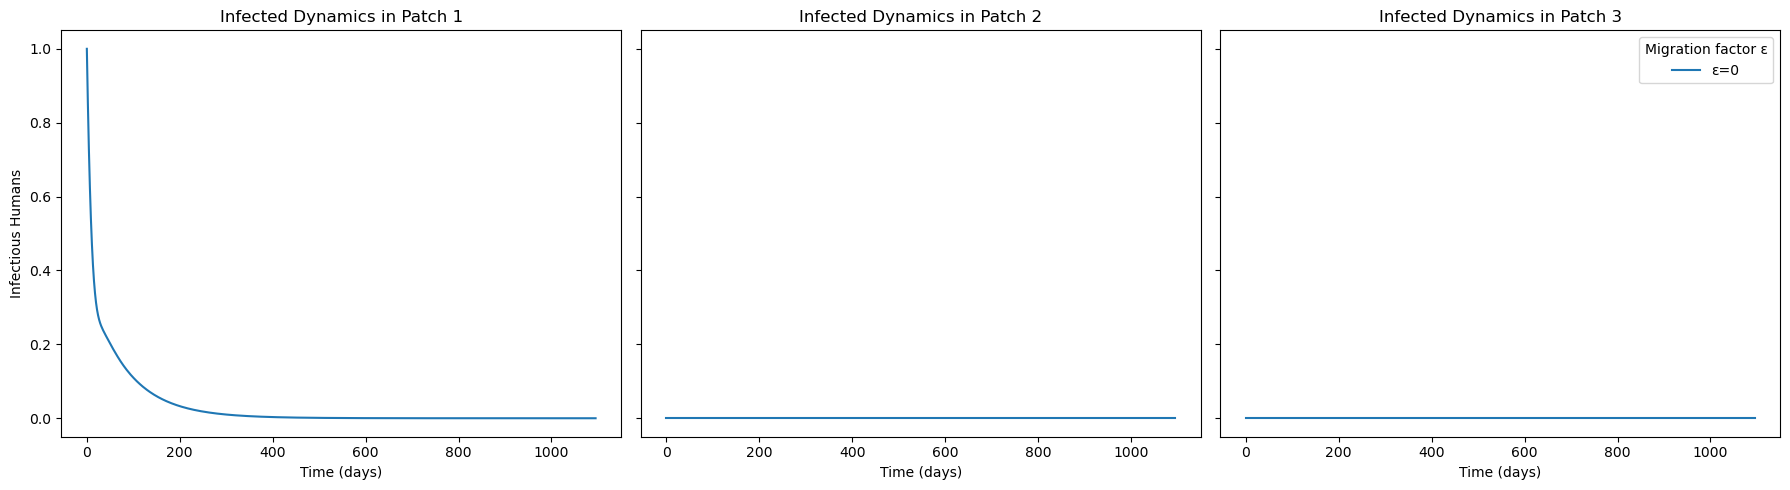

In [16]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Model Parameters
num_patches = 3
N_H = np.array([2000, 2000, 2000])
N_V = np.array([5000, 5000, 5000])

sigma_h = 1/10     # incubation rate (humans)
sigma_v = 1/7      # incubation rate (mosquitoes)
gamma_h = 1/14     # recovery rate (humans)
mu_h = 1/(70*365)  # human death rate
mu_v = 1/10        # mosquito death rate
delta_h = 0.001    # disease-induced death rate
omega_h = 1/180    # loss of immunity

# Growing population: birth rate slightly above natural death
birth_rate = mu_h + 0.00013

# Transmission parameters: patch 2 & 3 baseline
beta_v = np.array([0.05, 0.1, 0.3])

# Set raw_mig to zero (no migration)
raw_mig = 0 * np.array([
    [0.0,  0.05, 0.05],
    [0.05, 0.0,  0.05],
    [0.05, 0.05, 0.0 ]
])

def compute_threshold_beta(epsilon):
    """
    Threshold β_h such that R0_migration = 1 in Patch 1,
    using eps = epsilon (since raw_mig is zero, the eps term drops out).
    """
    eps = epsilon
    a = sigma_h + mu_h + eps * raw_mig[0].sum()
    b = mu_h + gamma_h + delta_h
    c = sigma_v + mu_v
    d = mu_v
    return (a * b * c * d) / (sigma_h * sigma_v * beta_v[0])

# Prepare a single epsilon
epsilon = 0
t_eval = np.linspace(0, 365*3, 500)
n_comp = 7

fig, axes = plt.subplots(1, num_patches, figsize=(18, 5), sharey=True)

# Use epsilon directly as migration rate (but raw_mig=0 → no actual migration)
eps = epsilon

# Compute β_h so that Patch 1 is below threshold (and others given fixed)
threshold_beta_h0 = compute_threshold_beta(epsilon)
beta_h = np.array([threshold_beta_h0 * 0.6, 0.1, 0.03])

# Build column-zero-sum migration matrix M
M = raw_mig.copy()
for j in range(num_patches):
    M[j, j] = -raw_mig[:, j].sum()

# Compute R0 with migration (should be local since raw_mig=0)
R0_vals = []
for i in range(num_patches):
    num = beta_h[i] * beta_v[i] * sigma_h * sigma_v
    denom = (sigma_h + mu_h + eps * raw_mig[i].sum()) \
            * (mu_h + gamma_h + delta_h) \
            * (sigma_v + mu_v) \
            * mu_v
    R0_vals.append(np.sqrt(num / denom))

df_R0 = pd.DataFrame({'Patch': ['1','2','3'], 'R0_mig': R0_vals})
print(f"\nEpsilon = {epsilon}")
print(df_R0.to_string(index=False))

# Define the SEIRS metapopulation ODE
def seirs_metapop(t, Y_flat):
    Y = Y_flat.reshape((num_patches, n_comp))
    dY = np.zeros_like(Y)
    for i in range(num_patches):
        S_H, E_H, I_H, R_H, S_V, E_V, I_V = Y[i]
        lambda_H = beta_h[i] * I_V / N_V[i]
        lambda_V = beta_v[i] * I_H / N_H[i]
        Lambda_H = birth_rate * N_H[i]

        # Human compartments
        dS_H = Lambda_H - lambda_H * S_H + omega_h * R_H - mu_h * S_H
        dE_H = lambda_H * S_H - sigma_h * E_H - mu_h * E_H
        dI_H = sigma_h * E_H - (gamma_h + mu_h + delta_h) * I_H
        dR_H = gamma_h * I_H - omega_h * R_H - mu_h * R_H

        # Vector compartments
        dS_V = -lambda_V * S_V + mu_v * (N_V[i] - S_V)
        dE_V = lambda_V * S_V - sigma_v * E_V - mu_v * E_V
        dI_V = sigma_v * E_V - mu_v * I_V

        # (No migration, but still included for structure)
        for j in range(num_patches):
            dS_H += eps * (M[i, j] * Y[j, 0])
            dE_H += eps * (M[i, j] * Y[j, 1])
            dR_H += eps * (M[i, j] * Y[j, 3])

        dY[i] = [dS_H, dE_H, dI_H, dR_H, dS_V, dE_V, dI_V]
    return dY.flatten()

# Initial conditions: one infected in patch 1
Y0 = []
for i in range(num_patches):
    Y0 += [N_H[i] - 1, 0, (1 if i == 0 else 0), 0, N_V[i], 0, 0]
Y0 = np.array(Y0)

sol = solve_ivp(seirs_metapop,
                (t_eval[0], t_eval[-1]),
                Y0,
                t_eval=t_eval,
                method='RK45')

# Check total human population at start and end
total_H = sol.y.reshape((num_patches, n_comp, -1))[:, :4, :].sum(axis=(0, 1))
print(f"Initial total humans = {total_H[0]:.2f}, Final total humans = {total_H[-1]:.2f}")

# Plot infectious humans for each patch
for i in range(num_patches):
    axes[i].plot(t_eval,
                 sol.y[i*n_comp + 2],
                 label=f'ε={epsilon}')
    axes[i].set_title(f'Infected Dynamics in Patch {i+1}')
    axes[i].set_xlabel('Time (days)')
    if i == 0:
        axes[i].set_ylabel('Infectious Humans')
    axes[i].grid(False)

axes[-1].legend(title='Migration factor ε')
plt.tight_layout()
plt.savefig('NO_mig_Ep=0.pdf')
plt.show()


## Case $\mathcal {R}_{01} =1.2$ with $\varepsilon=0$

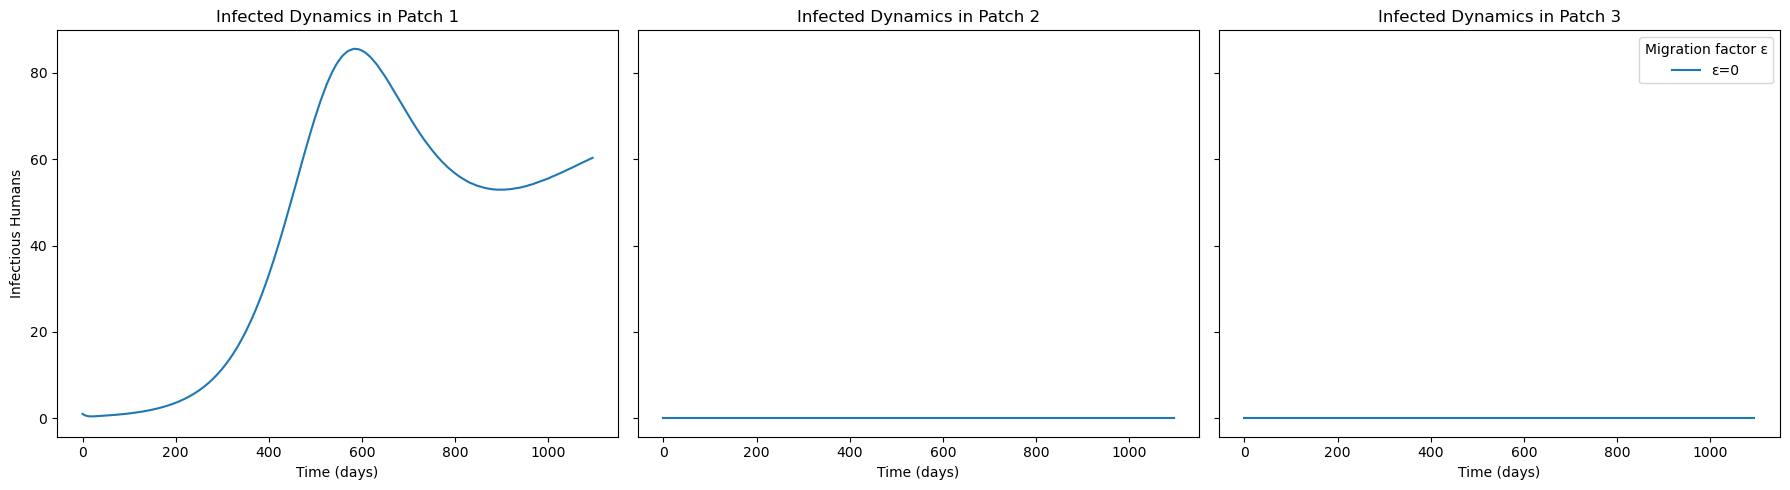

In [1]:
# Re-import all necessary libraries after code state reset
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Model Parameters
num_patches = 3
N_H = np.array([2000, 2000, 2000])
N_V = np.array([5000, 5000, 5000])

# Parameters for patch 1
mu_h = 1/(70*365)
sigma_h = 1/10
gamma_h = 1/14
delta_h = 0.001
omega_h = 1/180
mu_v = 1/10
sigma_v = 1/7
beta_v = np.array([0.05, 0.1, 0.3])  # mosquito-to-human transmission (per patch)
birth_rate = mu_h + 0.00013
lambda_vi = 0.01

# Migration setup
raw_mig = np.array([[0.0, 0.05, 0.05],
                    [0.05, 0.0, 0.05],
                    [0.05, 0.05, 0.0]])

def compute_threshold_beta(epsilon):
    eps = epsilon
    a = sigma_h + mu_h + eps * raw_mig[0].sum()
    b = mu_h + gamma_h + delta_h
    c = sigma_v + mu_v
    d = mu_v
    return (a * b * c * d) / (sigma_h * sigma_v * beta_v[0])

epsilon = 0
eps = epsilon
t_eval = np.linspace(0, 365*3, 500)
n_comp = 7

threshold_beta_h0 = compute_threshold_beta(epsilon)
beta_h = np.array([threshold_beta_h0 * 1.5, 0.14, 0.03])

# Build column-zero-sum migration matrix M
M = raw_mig.copy()
for j in range(num_patches):
    M[j, j] = -raw_mig[:, j].sum()

# R0 with migration
R0_vals = []
for i in range(num_patches):
    num = beta_h[i] * beta_v[i] * sigma_h * sigma_v
    denom = (sigma_h + mu_h + eps * raw_mig[i].sum()) * (mu_h + gamma_h + delta_h) * (sigma_v + mu_v) * mu_v
    R0_vals.append(np.sqrt(num / denom))
df_R0 = pd.DataFrame({'Patch': ['1', '2', '3'], 'R0_mig': R0_vals})

# ODE System
def seirs_metapop(t, Y_flat):
    Y = Y_flat.reshape((num_patches, n_comp))
    dY = np.zeros_like(Y)
    for i in range(num_patches):
        S_H, E_H, I_H, R_H, S_V, E_V, I_V = Y[i]
        lambda_H = beta_h[i] * I_V / N_V[i]
        lambda_V = beta_v[i] * I_H / N_H[i]
        Lambda_H = birth_rate * N_H[i]

        dS_H = Lambda_H - lambda_H * S_H + omega_h * R_H - mu_h * S_H
        dE_H = lambda_H * S_H - sigma_h * E_H - mu_h * E_H
        dI_H = sigma_h * E_H - (gamma_h + mu_h + delta_h) * I_H
        dR_H = gamma_h * I_H - omega_h * R_H - mu_h * R_H

        dS_V = -lambda_V * S_V + mu_v * (N_V[i] - S_V)
        dE_V = lambda_V * S_V - sigma_v * E_V - mu_v * E_V
        dI_V = sigma_v * E_V - mu_v * I_V

        for j in range(num_patches):
            dS_H += eps * (M[i, j] * Y[j, 0])
            dE_H += eps * (M[i, j] * Y[j, 1])
            dR_H += eps * (M[i, j] * Y[j, 3])

        dY[i] = [dS_H, dE_H, dI_H, dR_H, dS_V, dE_V, dI_V]
    return dY.flatten()

# Initial conditions
Y0 = []
for i in range(num_patches):
    Y0 += [N_H[i] - 1, 0, (1 if i == 0 else 0), 0, N_V[i], 0, 0]
Y0 = np.array(Y0)

sol = solve_ivp(seirs_metapop, (t_eval[0], t_eval[-1]), Y0, t_eval=t_eval, method='RK45')
total_H = sol.y.reshape((num_patches, n_comp, -1))[:, :4, :].sum(axis=(0, 1))

# Prepare figure
fig, axes = plt.subplots(1, num_patches, figsize=(18, 5), sharey=True)
for i in range(num_patches):
    axes[i].plot(t_eval, sol.y[i*n_comp + 2], label=f'ε={epsilon}')
    axes[i].set_title(f'Infected Dynamics in Patch {i+1}')
    axes[i].set_xlabel('Time (days)')
    if i == 0:
        axes[i].set_ylabel('Infectious Humans')
    axes[i].grid(False)
axes[-1].legend(title='Migration factor ε')
plt.tight_layout()

#import ace_tools as tools; tools.display_dataframe_to_user(name="R0 per Patch", dataframe=df_R0)
plt.show()
